In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

import os
import pickle
import random
import sys

from scipy.stats import ttest_ind
from torkin import TorKin

from config import Config
cfg = Config()

plt.rcParams['font.size'] = 18
plt.rc('font', size=18)
plt.rc('legend', fontsize=14)

In [2]:
root_dir = "/home/arash/catkin_ws/src/feedback_controller/fbc/neural_network/results/"
ds_name = "trajs:72_blocks:3" + "_triangle_v_scarce" #"_triangle_v"
model_params_list = [6.037, 12.053, 24.085] #, 36.117]

kin = TorKin()

No data file named /home/erhan/catkin_ws/src/erhtor_work/tormain/Resources/larm60.txt
bodypart structure for larm is constructed.
No data file named /home/erhan/catkin_ws/src/erhtor_work/tormain/Resources/rarm60.txt
bodypart structure for rarm is constructed.
bodypart structure for head is constructed.


### Example

In [3]:
model_name = "2+2l_lat:sub-nvel_1e-05"
ds_type = "extrap_0.85" #"interp_0.8"
file_root_dir = root_dir +\
    f"{ds_name}_{model_params_list[1]}K_{ds_type}/ep:4000/on_{model_name}" + "_True" + "_3l_base"

file_path = os.path.join(file_root_dir, "perf.csv")
df = pd.read_csv(file_path)  

In [4]:
df.head()

,eps_num,dnfc_succ,basel_succ,dnfc_dtw,basel_dtw,dnfc_norm,basel_norm
0,0,0.5,0.50,42.839557,62.794063,0.035729,0.052372
1,0,0.5,0.50,40.984353,67.274993,0.034182,0.056109
2,0,1.0,0.25,15.767249,47.761753,0.013150,0.039835
3,0,0.5,0.50,49.146961,51.334672,0.040990,0.042815
4,0,1.0,1.00,13.553805,19.268679,0.011304,0.016071


In [5]:
df.loc[3, 'dnfc_dtw']

49.14696110090848

In [6]:
df['dnfc_succ'] *= 100.0
df['basel_succ'] *= 100.0
df.head()

,eps_num,dnfc_succ,basel_succ,dnfc_dtw,basel_dtw,dnfc_norm,basel_norm
0,0,50.0,50.0,42.839557,62.794063,0.035729,0.052372
1,0,50.0,50.0,40.984353,67.274993,0.034182,0.056109
2,0,100.0,25.0,15.767249,47.761753,0.013150,0.039835
3,0,50.0,50.0,49.146961,51.334672,0.040990,0.042815
4,0,100.0,100.0,13.553805,19.268679,0.011304,0.016071


In [7]:
df['train_round'] = df.groupby('eps_num').cumcount() + 1
df.head(10)

,eps_num,dnfc_succ,basel_succ,dnfc_dtw,basel_dtw,dnfc_norm,basel_norm,train_round
0,0,50.0,50.0,42.839557,62.794063,0.035729,0.052372,1
1,0,50.0,50.0,40.984353,67.274993,0.034182,0.056109,2
2,0,100.0,25.0,15.767249,47.761753,0.013150,0.039835,3
3,0,50.0,50.0,49.146961,51.334672,0.040990,0.042815,4
4,0,100.0,100.0,13.553805,19.268679,0.011304,0.016071,5
5,1,50.0,50.0,31.869612,63.713227,0.026580,0.053139,1
6,1,50.0,50.0,43.413955,69.735609,0.036208,0.058161,2
7,1,100.0,25.0,9.945043,49.517110,0.008294,0.041299,3
8,1,50.0,50.0,34.285895,53.881672,0.028595,0.044939,4
9,1,100.0,25.0,13.610912,48.803041,0.011352,0.040703,5


In [8]:
df.shape

(55, 8)

In [9]:
# df = df[df["eps_num"] <= 32]
# df.shape

In [10]:
round_means = df.groupby('train_round')[['dnfc_succ', 'basel_succ',
                                         'dnfc_dtw', 'basel_dtw']].mean()

In [11]:
round_means

,dnfc_succ,basel_succ,dnfc_dtw,basel_dtw
train_round,,,,
1,40.909091,38.636364,46.377308,53.399446
2,45.454545,50.000000,47.634860,59.384603
3,100.000000,25.000000,13.268136,55.488562
4,56.818182,34.090909,39.073863,52.980085
5,77.272727,31.818182,23.771753,56.420603


In [12]:
round_means['dnfc_succ'].tolist()

[40.90909090909091,
 45.45454545454545,
 100.0,
 56.81818181818182,
 77.27272727272727]

In [13]:
overall_mean = round_means.mean()
overall_std = round_means.std()
print(overall_mean)
print("---")
print(overall_std)

dnfc_succ     64.090909
basel_succ    35.909091
dnfc_dtw      34.025184
basel_dtw     55.534660
dtype: float64
---
dnfc_succ     24.499115
basel_succ     9.287644
dnfc_dtw      14.993960
basel_dtw      2.583315
dtype: float64


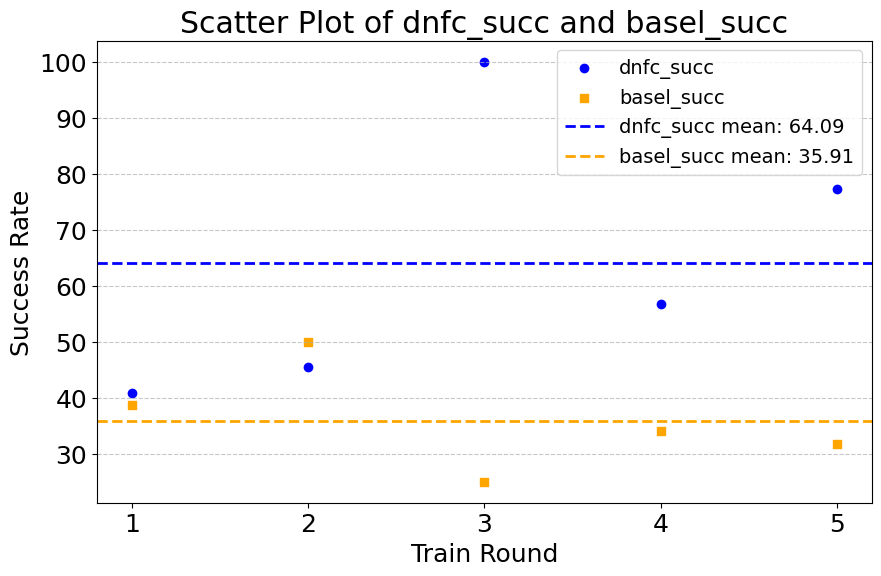

In [14]:
dnfc_succ = round_means['dnfc_succ'].tolist()
basel_succ = round_means['basel_succ'].tolist()

dnfc_mean = np.mean(dnfc_succ)
basel_mean = np.mean(basel_succ)

# Scatter plot
plt.figure(figsize=(10, 6))
train_rounds = np.arange(1, len(dnfc_succ)+1)

# Plot scatter points
plt.scatter(train_rounds, dnfc_succ, color='blue', label='dnfc_succ', marker='o')
plt.scatter(train_rounds, basel_succ, color='orange', label='basel_succ', marker='s')

# Add mean lines
plt.axhline(dnfc_mean, color='blue', linestyle='dashed', linewidth=2, 
            label=f'dnfc_succ mean: {dnfc_mean:.2f}')
plt.axhline(basel_mean, color='orange', linestyle='dashed', linewidth=2, 
            label=f'basel_succ mean: {basel_mean:.2f}')

# Labels and legend
plt.xlabel('Train Round')
plt.ylabel('Success Rate')
plt.title('Scatter Plot of dnfc_succ and basel_succ')
plt.xticks(train_rounds)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.savefig(os.path.join(os.getcwd(), "paper/each_model.png"))
plt.show()

In [15]:
df.shape

(55, 8)

### Performance

In [ ]:
stats_model = {
    'size': 0,
    'succ_mean': [],
    'succ_std': [],
    'dtw_mean': [],
    'dtw_std': [],

    'succ_arr' : [],
    'dtw_arr' : [],
}

stats_base = {
    'size': 0,
    'succ_mean': [],
    'succ_std': [],
    'dtw_mean': [],
    'dtw_std': [],

    'succ_arr' : [],
    'dtw_arr' : [],
}

stats_abl = {
    'size': 0,
    'succ_mean': [],
    'succ_std': [],
    'dtw_mean': [],
    'dtw_std': [],

    'succ_arr' : [],
    'dtw_arr' : [],
}

In [ ]:
for num_params in model_params_list:
    model_dir = os.path.join(root_dir, f"{ds_name}_{num_params}K_{ds_type}/ep:4000/")
    for is_not_abl in [True]:#, False]:
        file_dir = os.path.join(model_dir, f"on_{model_name}_{is_not_abl}" + "_3l_base")
        file_path = os.path.join(file_dir, "perf.csv")
        df = pd.read_csv(file_path)  
        print("df shape", df.shape)
        print("path", file_path, end="===\n")
        
        df['dnfc_succ'] *= 100.0
        df['basel_succ'] *= 100.0

        df['train_round'] = df.groupby('eps_num').cumcount() + 1
        # df = df[df["eps_num"] <= 32]
        round_means = df.groupby('train_round')[['dnfc_succ', 'basel_succ',
                                            'dnfc_dtw', 'basel_dtw']].mean()
        overall_mean = round_means.mean()
        overall_std = round_means.std()

        if is_not_abl:
            stats_model['succ_mean'].append(overall_mean['dnfc_succ'])
            stats_base['succ_mean'].append(overall_mean['basel_succ'])
            stats_model['dtw_mean'].append(overall_mean['dnfc_dtw'])
            stats_base['dtw_mean'].append(overall_mean['basel_dtw'])

            stats_model['succ_arr'].append(round_means['dnfc_succ'].tolist()) #dnfc_succ.tolist())
            stats_model['dtw_arr'].append(round_means['dnfc_dtw'].tolist()) #dnfc_dtw.tolist())

            stats_model['succ_std'].append(overall_std['dnfc_succ'])
            stats_base['succ_std'].append(overall_std['basel_succ'])
            stats_model['dtw_std'].append(overall_std['dnfc_dtw'])
            stats_base['dtw_std'].append(overall_std['basel_dtw'])

            stats_base['succ_arr'].append(round_means['basel_succ'].tolist()) #basel_succ.tolist())
            stats_base['dtw_arr'].append(round_means['basel_dtw'].tolist()) #basel_dtw.tolist())
        else:
            pass
            # stats_abl['succ_mean'].append(overall_mean['dnfc_succ'] * 100.0)
            # stats_abl['succ_std'].append(overall_std['dnfc_succ'] * 100.0)
            # stats_abl['dtw_mean'].append(overall_mean['dnfc_dtw'])
            # stats_abl['dtw_std'].append(overall_std['dnfc_dtw'])

            # stats_abl['succ_arr'].append(dnfc_succ.tolist())#round_means['dnfc_succ'].tolist())
            # stats_abl['dtw_arr'].append(dnfc_dtw.tolist())#round_means['dnfc_dtw'].tolist())

In [ ]:
print(len(stats_model['succ_arr'][0]))
stats_model

In [ ]:
print(len(stats_base['succ_arr'][0]))
stats_base

In [ ]:
print(len(stats_abl['succ_arr'][0]))
stats_abl

In [ ]:
for i in range(len(stats_model['succ_arr'])):
    print("succ_arr")
    statistic, pvalue = ttest_ind(stats_model['succ_arr'][i], 
                                 stats_base['succ_arr'][i], equal_var=False)
    print(len(stats_model['succ_arr'][i]), len(stats_base['succ_arr'][i]))
    print(statistic, pvalue)
    print("-")

    print("dtw_arr")
    statistic, pvalue = ttest_ind(stats_model['dtw_arr'][i], 
                                 stats_base['dtw_arr'][i], equal_var=False)
    print(len(stats_model['dtw_arr'][i]), len(stats_base['dtw_arr'][i]))
    print(statistic, pvalue)
    print("===")

#### Visualization

In [ ]:
Ys = {
    'DNFC': [x for x in stats_model['dtw_mean']],
    'Baseline': [x for x in stats_base['dtw_mean']],
    # 'DNFC-ablation': [x for x in stats_abl['dtw_mean']],
}

errors = {
    'DNFC': [x for x in stats_model['dtw_std']],
    'Baseline': [x for x in stats_base['dtw_std']],
    # 'DNFC-ablation': [x for x in stats_abl['dtw_std']],
}

x = np.arange(len(model_params_list))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained', figsize=(12, 8))

for attribute, measurement in Ys.items():
    offset = width * multiplier
    # print(attribute)
    rects = ax.bar(x + offset, measurement, width, label=attribute, yerr=errors[attribute],
                   error_kw={'capsize': 5})
    # ax.bar_label(rects, fmt='%.2f', padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel("DTW's distance")
ax.set_xlabel("Approximate number of model parameters (x1e3)")
# ax.set_title('Robot Endpoint-Target Distance')
ax.set_xticks(x + width, model_params_list)
# ax.legend(loc='upper left', ncols=3)
ax.legend()
# ax.set_ylim(0, 250)
plt.savefig(os.path.join(os.getcwd(), "paper/dtw.png"))
plt.show()
print(Ys)
print(errors)

In [ ]:
Ys = {
    'DNFC': [x for x in stats_model['succ_mean']],
    'Baseline': [x for x in stats_base['succ_mean']],
    # 'DNFC-ablation': [x for x in stats_abl['succ_mean']],
}

errors = {
    'DNFC': [x for x in stats_model['succ_std']],
    'Baseline': [x for x in stats_base['succ_std']],
    # 'DNFC-ablation': [x for x in stats_abl['succ_std']],
}

x = np.arange(len(model_params_list))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained', figsize=(12, 8))

for attribute, measurement in Ys.items():
    offset = width * multiplier
    # print(attribute)
    rects = ax.bar(x + offset, measurement, width, label=attribute, yerr=errors[attribute],
                   error_kw={'capsize': 5})
    # ax.bar_label(rects, fmt='%.2f', padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Success rate')
ax.set_xlabel("Approximate number of model parameters (x1e3)")
# ax.set_title('Robot Endpoint-Target Distance')
ax.set_xticks(x + width, model_params_list)
# ax.legend(loc='upper left', ncols=3)
ax.legend()
# ax.set_ylim(0, 250)
plt.savefig(os.path.join(os.getcwd(), "paper/succ.png"))
plt.show()
print(Ys)
print(errors)

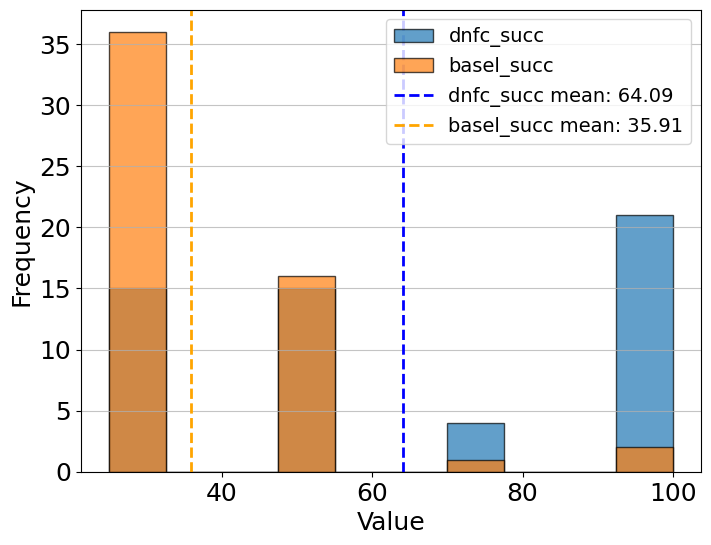

In [16]:
bin_no = 10

dnfc_mean = df["dnfc_succ"].mean()
basel_mean = df["basel_succ"].mean()

# Plot histograms for 'dnfc_succ' and 'basel_succ' side by side
plt.figure(figsize=(8, 6))
plt.hist(df["dnfc_succ"], bins=bin_no, alpha=0.7, label='dnfc_succ', edgecolor='black')
plt.hist(df["basel_succ"], bins=bin_no, alpha=0.7, label='basel_succ', edgecolor='black')
# plt.title("Histogram of dnfc_succ and basel_succ", fontsize=14)
# Add vertical dashed lines for mean values
plt.axvline(dnfc_mean, color='blue', linestyle='dashed', 
            linewidth=2, label=f'dnfc_succ mean: {dnfc_mean:.2f}')
plt.axvline(basel_mean, color='orange', linestyle='dashed', 
            linewidth=2, label=f'basel_succ mean: {basel_mean:.2f}')

plt.xlabel("Value")
plt.ylabel("Frequency")
plt.legend()
plt.grid(axis='y', alpha=0.75)

plt.savefig(os.path.join(os.getcwd(), "paper/succ_hist.png"))
plt.show()

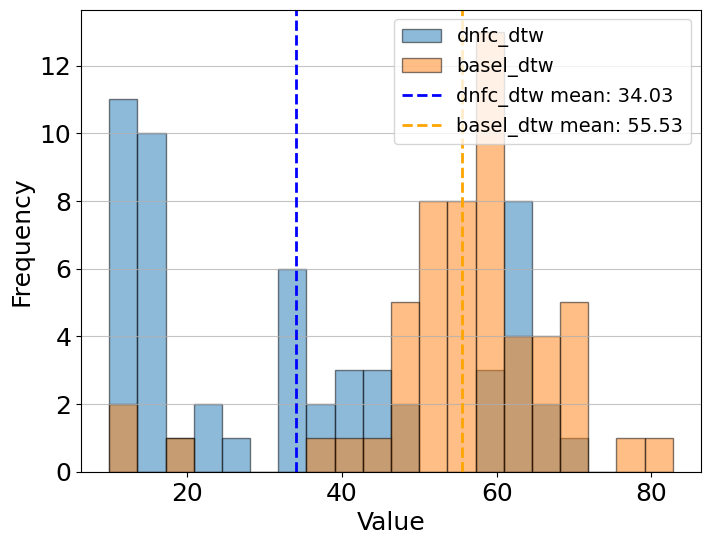

In [17]:
bin_no = 20

# Find the common range for both datasets
min_value = min(df["dnfc_dtw"].min(), df["basel_dtw"].min())
max_value = max(df["dnfc_dtw"].max(), df["basel_dtw"].max())

# Create bin edges with equal width
bins = np.linspace(min_value, max_value, bin_no + 1)  # +1 because linspace creates bin edges

dnfc_mean = df["dnfc_dtw"].mean()
basel_mean = df["basel_dtw"].mean()

# Plot histograms for 'dnfc_succ' and 'basel_succ' side by side
plt.figure(figsize=(8, 6))
plt.hist(df["dnfc_dtw"], bins=bins, alpha=0.5, label='dnfc_dtw', edgecolor='black')
plt.hist(df["basel_dtw"], bins=bins, alpha=0.5, label='basel_dtw', edgecolor='black')

plt.axvline(dnfc_mean, color='blue', linestyle='dashed', 
            linewidth=2, label=f'dnfc_dtw mean: {dnfc_mean:.2f}')
plt.axvline(basel_mean, color='orange', linestyle='dashed', 
            linewidth=2, label=f'basel_dtw mean: {basel_mean:.2f}')
# plt.title("Histogram of dnfc_succ and basel_succ", fontsize=14)
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.legend()
plt.grid(axis='y', alpha=0.75)

plt.savefig(os.path.join(os.getcwd(), "paper/dtw_hist.png"))
plt.show()


### Latent Space Rep.

In [ ]:
root_dir = "/home/arash/catkin_ws/src/feedback_controller/fbc/neural_network/results/"
root_dir += "trajs:360_blocks:3_triangle_v_7.541K/ep:1000/on_v_custl_const_1e-05"

In [ ]:
file_path = os.path.join(root_dir, "all_states_dnfc")
with open(file_path, 'rb') as f:
    all_states_dnfc = pickle.load(f)

In [ ]:
eps_no = 27

dnfc_data = all_states_dnfc[eps_no]

In [ ]:
joint_vals = [timestep_data[4] for timestep_data in dnfc_data]
timesteps = range(len(joint_vals))

plt.figure(figsize=(10, 6))
plt.plot(timesteps, joint_vals)
plt.xlabel("Timestep")
plt.ylabel("Value")
# plt.title("Fifth Value Across Timesteps")
# plt.legend()
plt.grid(True)
plt.show()

### Loss

In [ ]:
root_dir = "/home/arash/catkin_ws/src/feedback_controller/fbc/neural_network/weights/"
dnfc_dir = os.path.join(root_dir, 
                        "trajs:72_blocks:3_triangle_v_scarce|extrap_0.85|cus_los_1e-05|tar_cart|2+2l_lat:sub-nvel|24.085K_params")
base_dir = os.path.join(root_dir, 
                        "trajs:72_blocks:3_triangle_v_scarce|extrap_0.85|mse_los|tar_cart|base|3l_base|24.091K_params")

dnfc_fpath = os.path.join(dnfc_dir, "train_no_0/loss.csv")
df_dnfc = pd.read_csv(dnfc_fpath)
base_fpath = os.path.join(base_dir, "train_no_0/loss.csv")
df_base = pd.read_csv(base_fpath)

In [ ]:
df_dnfc.head()

In [ ]:
df_base.head()

In [ ]:
# Filter the dataframe for n >= 10
filtered_df = df_dnfc[(df_dnfc["n"] >= 100)] #& (df_dnfc["n"] <= 1000)]
filtered_df_base = df_base[(df_base["n"] >= 100)] #& (df_dnfc["n"] <= 1000)]

# Plot train_loss_torques and val_loss_torques vs n
plt.figure(figsize=(10, 8))
plt.plot(filtered_df["n"], np.log(filtered_df["train_loss_torques"]), 
         marker='o', linestyle='-', label="Train Trq DNFC")
plt.plot(filtered_df["n"], np.log(filtered_df["val_loss_torques"]), 
         marker='x', linestyle='-', label="Val Trq DNFC")
plt.plot(filtered_df["n"], np.log(filtered_df["train_loss_custom"]), 
         marker='o', linestyle='-', label="Train Cus DNFC")
plt.plot(filtered_df["n"], np.log(filtered_df["val_loss_cutsom"]), 
         marker='x', linestyle='-', label="Val Cus DNFC")

plt.plot(filtered_df_base["n"], np.log(filtered_df_base["train_loss_torques"]), 
         marker='o', linestyle='-', label="Train Trq Base")
plt.plot(filtered_df_base["n"], np.log(filtered_df_base["val_loss_torques"]), 
         marker='x', linestyle='-', label="Val Trq Base")
plt.xlabel("n")
plt.ylabel("Loss")
# plt.title("Train and Val Loss Torques vs n (n >= 100)")
plt.legend()
plt.grid(True)

loss_path = os.path.join(dnfc_dir, "loss.png")
plt.savefig(loss_path)
plt.show()


### Latent Representations

In [ ]:
def get_file(model_dir, is_not_abl, file_name):
    file_dir = os.path.join(model_dir, f"on_v_custl_mse_1e-05_{is_not_abl}")
    file_path = os.path.join(file_dir, f"{file_name}")
    with open(file_path, 'rb') as f:
        latent_reps = pickle.load(f)
    return latent_reps

def get_csv(model_dir, is_not_abl):
    file_dir = os.path.join(model_dir, f"on_v_custl_mse_1e-05_{is_not_abl}")
    file_path = os.path.join(file_dir, "perf.csv")
    df = pd.read_csv(file_path)  
    return df

def add_train_round(df):
    df['train_round'] = df.groupby('eps_num').cumcount() + 1
    return df

In [ ]:
def intrinsic_to_3d_cart(all_joints_vals):
    x, y, z = [], [], []
    for joints_vals in all_joints_vals:
        my_l = [0, 0]
        for j_val in joints_vals:
            my_l.append(float(j_val))
        p, R = kin.forwardkin(1, np.array(my_l))
        x.append(p[0])
        y.append(p[1])
        z.append(p[2])

    return x, y, z

In [ ]:
def plot_latent_reps(latent_reps, latent_reps_abl, states, states_abl,
                     df_perf, df_perf_abl, i_eps, model_dir):
    # Transpose the data to separate each joint
    lat_rep_transp = list(zip(*latent_reps))
    lat_rep_abl_transp = list(zip(*latent_reps_abl))
    states_transp = list(zip(*states))
    states_abl_transp = list(zip(*states_abl))

    # print(len(lat_rep_transp), len(lat_rep_transp[0]))
    # Plot each joint's position over time
    time_steps = range(len(latent_reps))  # Assuming each inner list corresponds to a timestep
    
    colors = [
        'blue', 'green', 'red', 'cyan', 'magenta', #'yellow', 
        'black', 'orange', 'purple', 'brown', 'pink', 'lime', 
        'teal', 'gold'
    ]
    
    # Create a figure with 7 subplots arranged vertically
    fig, axes = plt.subplots(7, 1, figsize=(12, 14), sharex=True)
    fig.tight_layout(pad=0.0)  # Adjust spacing between subplots

    for idx, lat_rep in enumerate(lat_rep_transp[:7]):
        ax = axes[idx]  # Select the subplot corresponding to the current index
        if idx < 7: label_st = f'Jnt.{idx + 1}'
        else: label_st = f'Vel.{(idx%7) + 1}'

        # print(len(lat_rep), len(lat_rep_abl_transp), len(states_transp))
        ax.plot(time_steps, lat_rep, 
                 label=f'Dim{idx + 1}', color=colors[idx])
        ax.plot(time_steps, lat_rep_abl_transp[idx], 
                 label=f'Dim{idx + 1}a', color=colors[idx], linestyle='dashed')
        ax.plot(time_steps, states_transp[idx], 
                 label=label_st, color=colors[idx])#<, linestyle='dashed')
        ax.plot(time_steps, states_abl_transp[idx], 
                 label=f'Jnt.{idx + 1}a', color=colors[idx], linestyle='dotted')
        
        # Add labels and legend to each subplot
        ax.set_ylabel(f'Dim {idx + 1}')
        ax.legend()
        ax.grid(True)

    eps_no = i_eps // 5
    train_no = i_eps % 5
    # Add a common xlabel and adjust layout
    axes[-1].set_xlabel('Time Steps')
    fig.suptitle(f"DNFC: {df_perf['dnfc_succ']}, DNFC-abl: {df_perf_abl['dnfc_succ']}")
    # plt.show()
    plot_dir = os.path.join(model_dir, f'latent_reps')
    if os.path.exists(plot_dir):
        pass
        # print("Latent dir. already exists. Are you trying to generate it again?")
        # sys.exit(1)
    else:
        os.makedirs(plot_dir)
    plot_path = os.path.join(plot_dir, f"eps:{eps_no}_train:{train_no}.png")
    plt.savefig(plot_path)
    plt.close()

In [ ]:
for num_params in model_params_list:
    model_dir = os.path.join(root_dir, f"trajs:360_blocks:3_triangle_v_{num_params}K/ep:1000/")
    latent_reps = get_file(model_dir, True, "all_latent_reps")
    latent_reps_abl = get_file(model_dir, False, "all_latent_reps")
    states_dnfc = get_file(model_dir, True, "all_states_dnfc")
    states_abl = get_file(model_dir, False, "all_states_dnfc")

    df_perf = get_csv(model_dir, True)
    df_perf = add_train_round(df_perf)
    df_perf_abl = get_csv(model_dir, False)
    df_perf_abl = add_train_round(df_perf_abl)
    # print(df_perf_abl.head(10))

    for i_eps in range(len(latent_reps)):
        plot_latent_reps(latent_reps[i_eps], 
                            latent_reps_abl[i_eps], 
                            states_dnfc[i_eps],
                            states_abl[i_eps], 
                            df_perf.loc[i_eps], df_perf_abl.loc[i_eps], i_eps, model_dir)